<a href="https://colab.research.google.com/github/Varun9213/Miscelaneous-Detection/blob/main/siimcovid_pytorch_effv2_AUX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/albu/albumentations --no-cache-dir -q
!pip -q install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip install git+https://github.com/qubvel/segmentation_models.pytorch -q
!pip install -q kaggle

     |████████████████████████████████| 81kB 10.7MB/s 
     |████████████████████████████████| 952kB 36.7MB/s 
     |████████████████████████████████| 37.2MB 1.3MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/gdrive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d awsaf49/siimcovid19-512-jpg-image-dataset
#!kaggle datasets download -d yasufuminakama/iterative-stratification

100% 439M/439M [00:04<00:00, 83.7MB/s]
100% 439M/439M [00:04<00:00, 93.5MB/s]


In [ ]:
!kaggle datasets download -d ipythonx/covid19-detection-890pxpng-study

 99% 2.84G/2.85G [00:31<00:00, 113MB/s]
100% 2.85G/2.85G [00:32<00:00, 95.7MB/s]


In [ ]:
!mkdir train
!mkdir mask
!unzip -q /content/siimcovid19-512-jpg-image-dataset.zip -d train
!unzip -q /content/covid19-detection-890pxpng-study.zip -d mask

In [ ]:
# !mkdir strat
# !unzip -q /content/iterative-stratification.zip -d strat

In [ ]:
!kaggle datasets download -d kozodoi/timm-pytorch-image-models

 35% 5.00M/14.2M [00:00<00:00, 32.2MB/s]
100% 14.2M/14.2M [00:00<00:00, 56.3MB/s]


In [ ]:
!mkdir timm
!unzip -q /content/timm-pytorch-image-models.zip -d timm 

In [ ]:
# !pip install -q /content/strat/iterative-stratification-master

In [ ]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pylab import rcParams
import seaborn as sns
import json

In [ ]:
cls = ["Negative for Pneumonia", "Typical Appearance", "Indeterminate Appearance", "Atypical Appearance"]

masks_path = '/content/mask/ROI Mask/'
train = pd.read_csv("/content/train/train.csv")
train["file_path"] = "/content/train/train/" + train["image_id"] + ".jpg"
train["class_name"] = np.argmax(train[cls].values, axis=1)
train["mask_path"] = masks_path + train["image_id"]  + ".png"
train.reset_index(inplace=True)

display(train.head())

,index,boxes,label,StudyInstanceUID,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,filepath,file_path,class_name,mask_path
0,0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,000a312787f2,0,1,0,0,/kaggle/input/siim-covid19-detection/train/577...,/content/train/train/000a312787f2.jpg,1,/content/mask/ROI Mask/000a312787f2.png
1,1,NaN,none 1 0 0 1 1,ff0879eb20ed,000c3a3f293f,1,0,0,0,/kaggle/input/siim-covid19-detection/train/ff0...,/content/train/train/000c3a3f293f.jpg,0,/content/mask/ROI Mask/000c3a3f293f.png
2,2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0012ff7358bc,0,1,0,0,/kaggle/input/siim-covid19-detection/train/9d5...,/content/train/train/0012ff7358bc.jpg,1,/content/mask/ROI Mask/0012ff7358bc.png
3,3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,001398f4ff4f,0,0,0,1,/kaggle/input/siim-covid19-detection/train/28d...,/content/train/train/001398f4ff4f.jpg,3,/content/mask/ROI Mask/001398f4ff4f.png
4,4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,001bd15d1891,0,1,0,0,/kaggle/input/siim-covid19-detection/train/dfd...,/content/train/train/001bd15d1891.jpg,1,/content/mask/ROI Mask/001bd15d1891.png


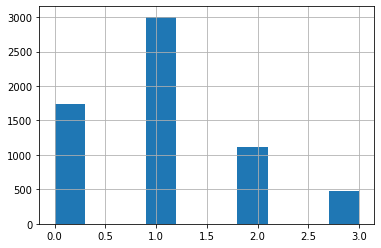

In [ ]:
train['class_name'].hist()

In [ ]:
class CFG:
    
    apex=True
    debug=False
    train=True
    mixup=False
    cont=True
    print_freq=100
    target_size=len(cls)
    target_col=cls
    trn_fold=[0,1,2,3,4]
    batch_size=20
    n_fold=5
    
    model_name='tf_efficientnetv2_m_in21ft1k'
    
    weights=[None]*n_fold

    # weights=["/content/gdrive/MyDrive/kaggle/results_siim_covid_tf_efficientnetv2_m/tf_efficientnetv2_m_fold0_best_score.pth",
    #          None,
    #          None,
    #          None,
    #          None]
    
    weights=["/content/gdrive/MyDrive/kaggle/results_siim_covid_tf_efficientnetv2_m_in21ft1k/tf_efficientnetv2_m_in21ft1k_fold0_best_score.pth",
             "/content/gdrive/MyDrive/kaggle/results_siim_covid_tf_efficientnetv2_m_in21ft1k/tf_efficientnetv2_m_in21ft1k_fold1_best_score.pth",
             "/content/gdrive/MyDrive/kaggle/results_siim_covid_tf_efficientnetv2_m_in21ft1k/tf_efficientnetv2_m_in21ft1k_fold2_best_score.pth",
             "/content/gdrive/MyDrive/kaggle/results_siim_covid_tf_efficientnetv2_m_in21ft1k/tf_efficientnetv2_m_in21ft1k_fold3_best_score.pth",
             "/content/gdrive/MyDrive/kaggle/results_siim_covid_tf_efficientnetv2_m_in21ft1k/tf_efficientnetv2_m_in21ft1k_fold4_best_score.pth"
             ]

    
    size_train=512
    size_mask=512
    scale=1.25
    
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 
                                            # 'CosineAnnealingWarmRestarts', 'GradualWarmupSchedulerV2']
    multiplier = 20
    warmup_epo = 5
    cosine_epo = 10
    #epochs = [warmup_epo + cosine_epo]*n_fold
    epochs=[7]*n_fold
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=17 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=[3e-5]*n_fold
    min_lr=7e-6
    weight_decay=0
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    num_workers=4
    freeze=False
    
if CFG.debug:
    
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [ ]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('/content/timm/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import functional as FV
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm
import segmentation_models_pytorch as smp

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

OUTPUT_DIR = f'/content/gdrive/MyDrive/kaggle/results_siim_covid_{CFG.model_name}/'


if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Python        : ' + sys.version.split('\n')[0])
print('Numpy         : ' + np.__version__)
print('Pandas        : ' + pd.__version__)
print('PyTorch       : ' + torch.__version__)
print('Albumentations: ' + A.__version__)
print('Timm          : ' + timm.__version__)

Python        : 3.7.10 (default, May  3 2021, 02:48:31) 
Numpy         : 1.19.5
Pandas        : 1.1.5
PyTorch       : 1.9.0+cu102
Albumentations: 0.5.2
Timm          : 0.4.12


In [ ]:
# CFG.best_score[0]=0.0
# CFG.best_loss[0]=np.inf
# CFG.best_score[1]=0.0
# CFG.best_loss[1]=np.inf
# CFG.best_score[2]=0.0 
# CFG.best_loss[2]=np.inf 
# CFG.best_score[3]=0.0 
# CFG.best_loss[3]=np.inf
# CFG.best_score[4]=0.0 
# CFG.best_loss[4]=np.inf

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = average_precision_score(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [ ]:
# y = train[cls].values
# X = train['image_id'].values

# train['fold'] = np.nan

# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
# mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, random_state=CFG.seed, shuffle=True)
# for i, (_, test_index) in enumerate(mskf.split(X, y)):
#     train.iloc[test_index, -1] = i
    
# train['fold'] = train['fold'].astype('int')
# display(train.groupby(['fold', 'class_name']).size())

In [ ]:
gkf  = GroupKFold(n_splits = CFG.n_fold)
train['fold'] = -1

for fold, (train_idx, val_idx) in enumerate(gkf.split(train, groups = train.image_id.tolist())):
    train.loc[val_idx, 'fold'] = fold
    
train['fold'] = train['fold'].astype('int')
display(train.groupby(['fold', 'class_name']).size())

fold  class_name
0     0             296
      1             614
      2             235
      3             122
1     0             368
      1             600
      2             208
      3              91
2     0             363
      1             596
      2             218
      3              90
3     0             378
      1             571
      2             227
      3              91
4     0             331
      1             626
      2             220
      3              89
dtype: int64

In [ ]:
class TrainDataset(Dataset):
    
  def __init__(self, df, transforms=None, train=True):
      
    super().__init__()
    self.df = df
    self.transforms = transforms
    self.train = train
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
          
    row = self.df.iloc[idx]
    img = cv2.imread(row.file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA)

    if self.train:
      mask = np.zeros([512,512])
      if row.mask_path.split("/")[-1] in os.listdir(masks_path):
          mask_c = cv2.imread(row.mask_path,cv2.IMREAD_GRAYSCALE)
          mask_c = cv2.resize(mask_c, mask.shape[0:2], interpolation = cv2.INTER_AREA)
          mask = (mask_c).astype(float)/255.0

    if self.transforms is not None:
        if self.train:
            transformed = self.transforms[0](image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]
            img = self.transforms[1](image=img)["image"]
            mask = torchvision.transforms.functional.to_tensor(mask)
        else:
            img = self.transforms(image=img)["image"]
    else:
        img = torchvision.transforms.functional.to_tensor(img).float()
        mask = torchvision.transforms.functional.to_tensor(mask).float()
        
    # if row.mask_path.split("/")[-1] not in os.listdir(masks_path):
    #     mask = torch.ones([1,CFG.size_train,CFG.size_train]) * -100

    label = torch.as_tensor(row[CFG.target_col].astype('int').values)
    #label = torch.argmax(torch.as_tensor(label))
    
    if self.train:
      return img.float()/255.0, label.float(), mask.float()
    
    return img.float()/255.0, label.float()

In [ ]:
# Dual Cutout implementations
class CutoutV2(A.DualTransform):
    def __init__(
        self,
        num_holes=8,
        max_h_size=8,
        max_w_size=8,
        fill_value=0,
        always_apply=False,
        p=0.5,
    ):
        super(CutoutV2, self).__init__(always_apply, p)
        self.num_holes = num_holes
        self.max_h_size = max_h_size
        self.max_w_size = max_w_size
        self.fill_value = fill_value

    def apply(self, image, fill_value=0, holes=(), **params):
        return A.functional.cutout(image, holes, fill_value)

    def get_params_dependent_on_targets(self, params):
        img = params["image"]
        height, width = img.shape[:2]

        holes = []
        for _n in range(self.num_holes):
            y = random.randint(0, height)
            x = random.randint(0, width)

            y1 = np.clip(y - self.max_h_size // 2, 0, height)
            y2 = np.clip(y1 + self.max_h_size, 0, height)
            x1 = np.clip(x - self.max_w_size // 2, 0, width)
            x2 = np.clip(x1 + self.max_w_size, 0, width)
            holes.append((x1, y1, x2, y2))

        return {"holes": holes}

    @property
    def targets_as_params(self):
        return ["image"]

    def get_transform_init_args_names(self):
        return ("num_holes", "max_h_size", "max_w_size")

In [ ]:
def get_transforms():

    transforms_train_all = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomSizedCrop(min_max_height=(380, 380), height=512, width=512, p=0.75),
        #A.RandomResizedCrop(CFG.size_train,CFG.size_train#, scale=(0.33, 1.0), ratio=(0.75, 1.33)
        #),
        A.Resize(CFG.size_train, CFG.size_train),
        A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=30, border_mode=0, p=0.75),
    ])    

    transforms_train_image = A.Compose([
        A.RandomBrightnessContrast (brightness_limit=0.2, contrast_limit=0.2, p=0.75),
        CutoutV2(max_h_size=int(CFG.size_train * 0.1), max_w_size=int(CFG.size_train * 0.1), num_holes=4, p=0.75),
        ToTensorV2()
    ])
    
    transforms_val = A.Compose([                      
        A.Resize(int(CFG.size_train*CFG.scale), int(CFG.size_train*CFG.scale)),
        ToTensorV2()
    ])
    
    return (transforms_train_all, transforms_train_image), transforms_val

In [ ]:
transforms_train, transforms_valid = get_transforms()
ds = TrainDataset(df=train, transforms=transforms_train)
i=0
print(ds[i][1], ds[i][2].shape)

tensor([0., 1., 0., 0.]) torch.Size([1, 512, 512])


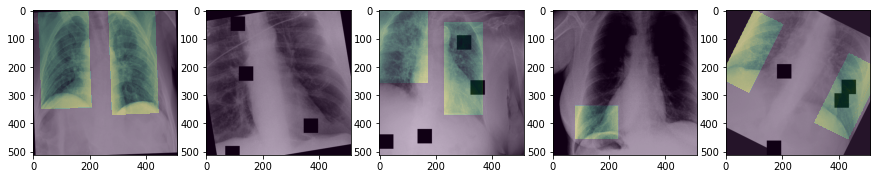

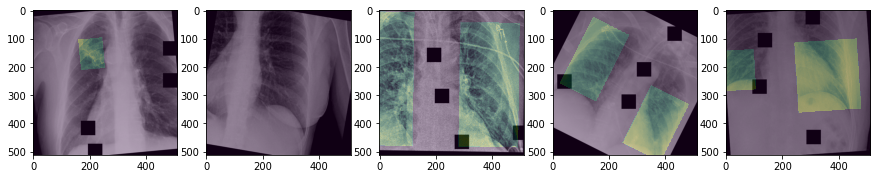

In [ ]:
def draw_outline(obj):
    obj.set_path_effects([patheffects.Stroke(linewidth=4, foreground='black'), patheffects.Normal()])

def draw_box(ax, bb):
    patch = ax.add_patch(patches.Rectangle((bb[0],bb[1]), bb[2], bb[3], fill=False, edgecolor='red', lw=2))
    draw_outline(patch)

rcParams['figure.figsize'] = 15,5
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = i*5 + p
        img, label, mask = ds[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].imshow(mask.squeeze(), interpolation='none', alpha=0.25)
        

In [ ]:
from timm.models.efficientnet import *

class MixedNet(nn.Module):
    def __init__(self, cfg):
        super(MixedNet, self).__init__()

        self.cfg = cfg
        e = tf_efficientnetv2_l_in21ft1k(pretrained=True, drop_rate=0.3, drop_path_rate=0.2)
        self.b0 = nn.Sequential(
            e.conv_stem,
            e.bn1,
            e.act1,
        )
        self.b1 = e.blocks[0]
        self.b2 = e.blocks[1]
        self.b3 = e.blocks[2]
        self.b4 = e.blocks[3]
        self.b5 = e.blocks[4]
        self.b6 = e.blocks[5]
        self.b7 = e.blocks[6]
        self.b8 = nn.Sequential(
            e.conv_head, #384, 1536
            e.bn2,
            e.act2,
        )

        self.logit = nn.Linear(1280,self.cfg.target_size)
        self.mask = nn.Sequential(
            nn.Conv2d(224, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1, padding=0),
        )

    def forward(self, image, train=True):
        batch_size = len(image)
        x = 2*image-1     # ; print('input ',   x.shape)

        x = self.b0(x) #; print (x.shape)  # torch.Size([2, 32, 256, 256])
        x = self.b1(x) #; print (x.shape)  # torch.Size([2, 32, 256, 256])
        x = self.b2(x) #; print (x.shape)  # torch.Size([2, 64, 128, 128])
        x = self.b3(x) #; print (x.shape)  # torch.Size([2, 96, 64, 64])
        x = self.b4(x) #; print (x.shape)  # torch.Size([2, 192, 32, 32])
        x = self.b5(x) #; print (x.shape)  # torch.Size([2, 176, 32, 32])
        #------------
        mask = self.mask(x)
        #-------------
        x = self.b6(x) #; print (x.shape)  # torch.Size([2, 384, 16, 16])
        x = self.b7(x) #; print (x.shape)  # torch.Size([2, 640, 16, 16])
        x = self.b8(x) #; print (x.shape)  # torch.Size([2, 1280, 16, 16])
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        x = F.dropout(x, 0.5, training=self.training)
        logit = self.logit(x)
        if train:
          return mask, logit
        return logit


In [ ]:
m = MixedNet(CFG)
x = torch.stack([ds[i][0] for i in range(2)])
y = m(x)
m_shape=y[0].shape[-1]
m_shape

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_l_21ft1k-60127a9d.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_l_21ft1k-60127a9d.pth


24

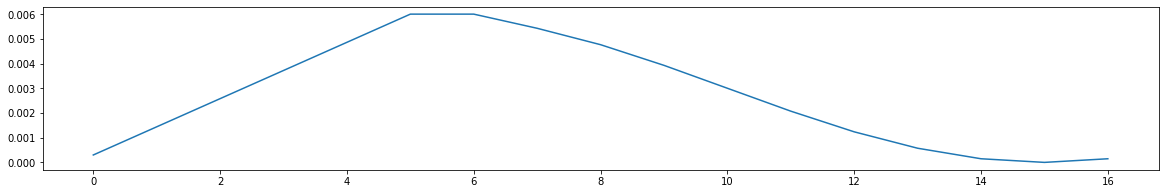

In [ ]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
        
optimizer = torch.optim.Adam(m.parameters(), lr=CFG.lr[0])
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=CFG.multiplier, total_epoch=CFG.warmup_epo, after_scheduler=scheduler_cosine)
lrs = []
for epoch in range(1, CFG.epochs[0]+1):
    scheduler_warmup.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
rcParams['figure.figsize'] = 20,3
plt.plot(lrs)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion,  optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels, masks) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
            
        images = images.to(device)
        labels = labels.to(device)
        masks = masks.to(device)
        masks = F.interpolate(masks, size=(m_shape,m_shape), mode='bilinear', align_corners=False)
        batch_size = len(labels)
        
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds, (masks, labels))
        else:
            y_preds = model(images)
            loss = criterion(y_preds, (masks, labels))
        
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = len(labels)
        # compute loss
        with torch.no_grad():
            y_preds = model(images, train=False)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        act = nn.Softmax(1)
        preds.append(act(y_preds).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [ ]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    

    if CFG.cont and best_size>0:
      CFG.scale=best_size/CFG.size_train
    
    
    transform_train, transform_valid = get_transforms()

    train_dataset = TrainDataset(train_folds, 
                                 transforms=transform_train,
                                 train=True)
    
    valid_dataset = TrainDataset(valid_folds, 
                                 transforms=transform_valid,
                                 train=False)

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, 
                                          verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, 
                                                    last_epoch=-1)
            
        elif CFG.scheduler=='GradualWarmupSchedulerV2':
            scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.cosine_epo)
            scheduler = GradualWarmupSchedulerV2(optimizer, multiplier=CFG.multiplier, 
                            total_epoch=CFG.warmup_epo, after_scheduler=scheduler_cosine)
            
        return scheduler

    # ====================================================
    # Loss Function , dtype=torch.int64
    # ====================================================

    class CompositeLoss(nn.Module):
        #smp.losses.DiceLoss(mode='multiclass', smooth=0.05)
        def __init__(self, losses=[smp.losses.SoftBCEWithLogitsLoss(ignore_index=-100), 
                                   smp.losses.LovaszLoss(mode="binary", ignore_index=-100), 
                                   nn.BCEWithLogitsLoss()
                                  ], weights=[1.0, 1.0, 1.0]):
            super().__init__()
            assert len(losses) == len(weights)
            self.losses = losses
            self.weights = weights

        def forward(self, approxs, targets):
            total_loss = 0.0
            for i in range(len(self.losses)):
                if i==len(self.losses)-1:
                  tar=targets[1]
                  app=approxs[1]
                else:
                  tar=targets[0]
                  app=approxs[0]

                total_loss += self.weights[i] * self.losses[i](
                    app, tar)
            return total_loss    


    def save(path, epoch):
        self.model.eval()
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_summary_loss': best_loss,
            'best_summary_score': best_score,
            'best_summary_size': best_size
            'epoch': epoch,
        }, path)


    def load(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_summary_loss']
        best_score = checkpoint['best_summary_score']
        best_size = checkpoint['best_summary_size']
        cont_epoch = checkpoint['epoch']

    # ====================================================
    # model & optimizer
    # ====================================================
    model = MixedNet(CFG)
    optimizer = Adam(model.parameters(), lr=CFG.lr[fold], weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    best_score = 0
    best_loss = np.inf
    best_size = 0

    if CFG.checkpoint[fold] is not None:
        print(f"Loading checkpoint for fold-{fold}.......")
        load(CFG.checkpoint[fold])

    model.to(device)

    LOGGER.info(f"\nBest Score : {best_score}\nBest Loss : {best_loss}\nBest Size : {best_size}\n")
    # ====================================================
    # loop
    # ====================================================
    train_criterion = CompositeLoss(weights=[1,1,1])
    val_criterion = nn.BCEWithLogitsLoss()

    if CFG.train:
      for epoch in range(1,CFG.epochs[fold]+1):

          if epoch==1:

            gpu_info = !nvidia-smi
            gpu_info = '\n'.join(gpu_info)
            if gpu_info.find('failed') >= 0:
              print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
              print('and then re-execute this cell.')
            else:
              print(gpu_info)
          
          start_time = time.time()
          
          # train
          avg_loss = train_fn(train_loader, model, train_criterion, optimizer, cont_epochs+epoch, scheduler, device)

          # eval
          avg_val_loss, preds = valid_fn(valid_loader, model, val_criterion, device)
          
          if isinstance(scheduler, ReduceLROnPlateau):
              scheduler.step(avg_val_loss)
          elif isinstance(scheduler, CosineAnnealingLR):
              scheduler.step()
          elif isinstance(scheduler, CosineAnnealingWarmRestarts):
              scheduler.step()
          elif isinstance(scheduler, GradualWarmupSchedulerV2):
            scheduler.step()

          # scoring
          score = get_score(valid_labels, preds) * (2/3)
          AP_1 = get_score(valid_labels[:,0], preds[:,0]) * (1/6)
          AP_2 = get_score(valid_labels[:,1], preds[:,1]) * (1/6)
          AP_3 = get_score(valid_labels[:,2], preds[:,2]) * (1/6)
          AP_4 = get_score(valid_labels[:,3], preds[:,3]) * (1/6)

          elapsed = time.time() - start_time

          LOGGER.info(f'\nEpoch {cont_epochs+epoch} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
          LOGGER.info(f'\nScore - {cls[0]}: {AP_1:.4f}')
          LOGGER.info(f'Score - {cls[1]}: {AP_2:.4f}')
          LOGGER.info(f'Score - {cls[2]}: {AP_3:.4f}')
          LOGGER.info(f'Score - {cls[3]}: {AP_4:.4f}')
          LOGGER.info(f'Overall Score: {score:.4f}\n')

          if score > best_score:
              best_score = score
              LOGGER.info(f'Epoch {cont_epochs+epoch} - Save Best Score: {best_score:.4f} Model')
              save(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.bin')
          
    else:
      avg_val_loss, preds = valid_fn(valid_loader, model, val_criterion, device)

      score = get_score(valid_labels, preds) * (2/3)
      AP_1 = get_score(valid_labels[:,0], preds[:,0]) * (1/6)
      AP_2 = get_score(valid_labels[:,1], preds[:,1]) * (1/6)
      AP_3 = get_score(valid_labels[:,2], preds[:,2]) * (1/6)
      AP_4 = get_score(valid_labels[:,3], preds[:,3]) * (1/6)

      LOGGER.info(f'\nScore - {cls[0]}: {AP_1:.4f}')
      LOGGER.info(f'Score - {cls[1]}: {AP_2:.4f}')
      LOGGER.info(f'Score - {cls[2]}: {AP_3:.4f}')
      LOGGER.info(f'Score - {cls[3]}: {AP_4:.4f}')
      LOGGER.info(f'Overall Score: {score:.4f}\n')

      if score > best_score:
              best_score = score
              LOGGER.info(f'Epoch {cont_epochs+epoch} - Save Best Score: {best_score:.4f} Model')
              save(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.bin')


    return best_score, best_loss, best_size

In [ ]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    # train 
    fold_best_scores=[]
    fold_best_losses=[]
    fold_best_size=[]
    for fold in range(CFG.n_fold):

        if fold in CFG.trn_fold:
            score, loss, size = train_loop(train, fold)
            fold_best_scores.append(score)
            fold_best_losses.append(loss)
            fold_best_size.append(size)
        else:
            fold_best_scores.append(CFG.best_score[fold])
            fold_best_losses.append(CFG.best_loss[fold])
            fold_best_size.append(CFG.best_size[fold])

    metrics={}
    metrics["scores"]=fold_best_scores
    metrics["losses"]=fold_best_losses
    metrics["size"]=fold_best_size
    
    with open(OUTPUT_DIR+"metrics.json", "w") as metricsfile:
      json.dump(metrics, metricsfile, indent=4)



In [ ]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========

Best Score : 0.3971134301644442
Best Loss : 0.3624926840073496
Best Size : 480



Loading pre-trained weights for fold-0.......
EVAL: [0/40] Data 0.994 (0.994) Elapsed 0m 2s (remain 1m 35s) Loss: 0.3462(0.3462) 



Score - Negative for Pneumonia: 0.1317
Score - Typical Appearance: 0.1437
Score - Indeterminate Appearance: 0.0550
Score - Atypical Appearance: 0.0667
Overall Score: 0.3971

Best Score: 0.3971 Model


EVAL: [39/40] Data 0.000 (0.025) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4414(0.3625) 


Best Loss: 0.3625
Best Size: 480
========== fold: 0 result ==========
Score: 0.3971
========== fold: 1 training ==========

Best Score : 0.3918269846640073
Best Loss : 0.3415658767992997
Best Size : 480



Loading pre-trained weights for fold-1.......
EVAL: [0/40] Data 1.081 (1.081) Elapsed 0m 1s (remain 1m 16s) Loss: 0.3830(0.3830) 



Score - Negative for Pneumonia: 0.1371
Score - Typical Appearance: 0.1484
Score - Indeterminate Appearance: 0.0538
Score - Atypical Appearance: 0.0525
Overall Score: 0.3918

Best Score: 0.3918 Model


EVAL: [39/40] Data 0.000 (0.027) Elapsed 0m 34s (remain 0m 0s) Loss: 0.5206(0.3416) 


Best Loss: 0.3416
Best Size: 480
========== fold: 1 result ==========
Score: 0.3918
========== fold: 2 training ==========

Best Score : 0.38223977070438586
Best Loss : 0.3512842480884167
Best Size : 480



Loading pre-trained weights for fold-2.......
EVAL: [0/40] Data 1.043 (1.043) Elapsed 0m 1s (remain 1m 15s) Loss: 0.3005(0.3005) 



Score - Negative for Pneumonia: 0.1366
Score - Typical Appearance: 0.1429
Score - Indeterminate Appearance: 0.0584
Score - Atypical Appearance: 0.0442
Overall Score: 0.3822

Best Score: 0.3822 Model


EVAL: [39/40] Data 0.000 (0.026) Elapsed 0m 34s (remain 0m 0s) Loss: 0.3425(0.3513) 


Best Loss: 0.3513
Best Size: 480
========== fold: 2 result ==========
Score: 0.3822
========== fold: 3 training ==========

Best Score : 0.3777476964366427
Best Loss : 0.37000056924835
Best Size : 480



Loading pre-trained weights for fold-3.......
EVAL: [0/40] Data 1.446 (1.446) Elapsed 0m 2s (remain 1m 30s) Loss: 0.4692(0.4692) 



Score - Negative for Pneumonia: 0.1344
Score - Typical Appearance: 0.1385
Score - Indeterminate Appearance: 0.0518
Score - Atypical Appearance: 0.0531
Overall Score: 0.3777

Best Score: 0.3777 Model


EVAL: [39/40] Data 0.000 (0.036) Elapsed 0m 35s (remain 0m 0s) Loss: 0.5441(0.3752) 


Best Loss: 0.3752
Best Size: 480
========== fold: 3 result ==========
Score: 0.3777
========== fold: 4 training ==========

Best Score : 0.3814822572996315
Best Loss : 0.3638768972472934
Best Size : 480



Loading pre-trained weights for fold-4.......
EVAL: [0/40] Data 1.421 (1.421) Elapsed 0m 2s (remain 1m 29s) Loss: 0.2709(0.2709) 



Score - Negative for Pneumonia: 0.1340
Score - Typical Appearance: 0.1394
Score - Indeterminate Appearance: 0.0561
Score - Atypical Appearance: 0.0521
Overall Score: 0.3815

Best Score: 0.3815 Model


EVAL: [39/40] Data 0.000 (0.036) Elapsed 0m 35s (remain 0m 0s) Loss: 0.2505(0.3669) 


Best Loss: 0.3669
Best Size: 480
========== fold: 4 result ==========
Score: 0.3815
========== CV ==========
Score: 0.3820


In [ ]:
# fold_best_scores=[0.3859, 0.3860, 0.3668, 0.3650, 0.0]
# fold_best_losses=[0.8668, 0.8211, 0.8387, 0.8774, np.inf]
# metrics={}
# metrics["scores"]=fold_best_scores
# metrics["losses"]=fold_best_losses

# with open(OUTPUT_DIR+"metrics.json", "w") as metricsfile:
#   json.dump(metrics, metricsfile, indent=4)